In [1]:
import numpy as np
import time
import requests
import pandas as pd

**Generate an SDE Realization**

*GenerateSDERealization* takes the following arguments:

- a starting value S0
- a function $f$ of two floating point variables that returns a single value floating point value
- a function $g$ of two floating point variables that returns a single value floating point value
- a positive number $T$
- a positive integer $N$

and which returns a 2-tuple containing two **numpy arrays**. 

- an array of values $0,\Delta,2\Delta,\ldots,T$ where $\Delta=T/N,$
- an array containing values $S_0=S0,S_\Delta,\ldots,S_T$ for a realization as described above.

The following cell allows you to generate realizations for various processes satisying the SDE

$$
dS_t = f(t,S_t) dt + g(t,S_t) dB_t
$$

by just changing the functions $f$ and $g$ and using them as arguments to our function.

In [2]:
def GenerateSDERealization(S0,f,g,T,N):
    # calculate parameters
    d = T/N
    sqrt_d = np.sqrt(d)
    icm = np.arange(N+1)*d # increment array
    sigma = np.random.normal(0,1,size=N)
    d_g = sigma*sqrt_d
    S = np.zeros(N) # St array
    S = np.insert(S,0,S0) 
    for i in range(N):
        t = i*d
        S[i+1] = S[i] + f(t,S[i])*d + g(t,S[i])*d_g[i]
    return(icm,S)

**Plotting a realization**

Test that plots of your realizations look reasonable using the code below. 

0.022417783737182617


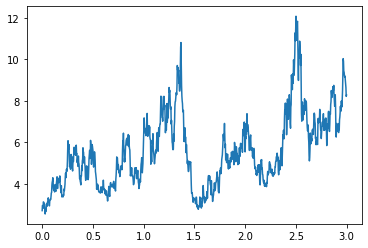

In [3]:
import matplotlib.pyplot as plt

start_time=time.time()
ntrials=1000
N=1000
T=3
mu=.01
sigma=.25
S0=1
G0=np.exp(S0)

def f(t,x):
    return(np.sin(t)*np.cos(x))
def g(t,x):
    return(1+.1*np.sin(t))
Tvec,Svec=GenerateSDERealization(S0,f,g,T,N)
Gvec=np.exp(Svec)
plt.plot(Tvec,Gvec)

end_time=time.time()
print(end_time-start_time)

**Testing Ito's Lemma: A Special Case**
**GBM2Versions** takes as input 
- **G0** a starting value G0
- **mu**  a constant 
- **sigma** a (positive) constant 
- **T** a (positive) constant  
- **N** a (positive) integer

In [4]:
def GBM2Versions(G0,mu,sigma,T,N):
    f1 = lambda t,x: mu
    g1 = lambda t,x: sigma
    f2 = lambda t,x: (mu + 0.5*np.square(sigma))*x
    g2 = lambda t,x: sigma*x
    np.random.seed(688)
    col0,B = GenerateSDERealization(0,f1,g1,T,N)
    col1 = G0*np.exp(B)
    np.random.seed(688)
    _,col2 = GenerateSDERealization(G0,f2,g2,T,N)
    return(np.column_stack((col0,col1,col2)))

**Generating GBM at given time points (not necessarily equi-spaced)**

**GenerateGBMRealization** takes as one arguments 

- **G0** a starting point for realizations of GBM
- **mu** the drift parameter
- **sigma** the volatility parameter
- **T** a 1-d numpy array of times in strictly increasing order with **T[0]=0** assumed

at which we want to generate a single realization of GBM process starting with value **G0** at time 0 and with parameters **mu** and **sigma** at at those times in the array **T**.

The function returns


- a numpy array that has two columns and number of rows equal to the number of entries in T.

In [5]:
def GenerateGBMRealization(G0,mu,sigma,T):
    N = len(T)
    dT = np.diff(T)
    sqrt_dT = np.sqrt(dT)
    noise = np.random.normal(0,1,size=N-1)
    G = np.zeros(N)
    G[0]=G0 
    for i in range(1,N):
        G[i] = G[i-1] + mu*dT[i-1] + sigma*noise[i-1]*sqrt_dT[i-1]  
    col1 = G0*np.exp(G)
    return(np.column_stack((T,col1)))

**GBM Calibration**

**GBMCalibration** takes as input

an (N+1) x 2 numpy array where the first column is the times $t$ at which a GBM process is observed, and the second column is the values $G_t$ of the GBM observed at those times, and returns a 2-tuple consisting of
$\hat{\mu}$ and $\hat{\sigma}$

In [6]:
def GBMCalibration(M):
    t = M[:,0]
    dt = np.diff(t)
    G = M[:,1]
    logG = np.log(G)
    dlogG = np.diff(logG)
    N = len(t)-1
    mu_hat = (logG[N]-logG[0])/(t[N]-t[0])
    d = np.square(dlogG-mu_hat*dt)/dt
    sigma_hat = np.sqrt(d.sum()/N)
    return(mu_hat,sigma_hat)

**Testing the GBMCalibration Code**

**TestCalibration** takes 3 arguments 

**G0** = starting point for GBM
**mu** = the drift parameter
**sigma** = the volatility parameter
**MaxT** = largest possible value of time at which GBM could be observed
**N** = number (greater than 2) of times (positive integer)at which GBM samples are observed

- generate a 1-d numpy array of **N-2** times uniformly distributed in the interval **[0,MaxTime]**, adjoin the values **0** and **MaxT** to the array, and sort it in increasing order to give a 1-d array with **N** values, **0** being the miniumum and **MaxT** being the maximum. 

- generate a GBM realization using the parameters **G0**, **mu**, and **sigma** observed at the times in your array of times

- call the GBMCalibration function using those times and observations

and finally return the pair of parameter estimates (**mu**,**sigma**) obtained from the GMBCalibration function.

For large values of N and MaxT, the estimates resemble the *true* values of **mu** and **sigma**  used to generate the realizations.

In [7]:
def TestGBMCalibration(G0,mu,sigma,MaxT,N):
    t = np.random.uniform(low=0, high=MaxT, size=N-2)
    t = np.insert(t,[0,N-2],[0,MaxT])
    T = np.sort(t)
    M = GenerateGBMRealization(G0,mu,sigma,T)
    return(GBMCalibration(M))

**FitGBMToData** takes a **single argument**, namely, 

- filepath = path to a data file on disk

The function reads in the data from one of the files, fit a GBM model using your calibration function and return the pair consisting of fitted values of **mu** and **sigma**.

In [8]:
def FitGBMToData(filepath):
    df = pd.read_csv(filepath,usecols=['Date', 'Adj Close**'])
    df = df.iloc[:-1,:]
    idx = pd.date_range(start=df.iloc[-1,0], end=df.iloc[0,0])
    df.index = pd.DatetimeIndex(df.Date)
    df = df.reindex(idx, fill_value=0)
    closeP=np.array([str(i).replace(",", "") for i in df['Adj Close**']],dtype='float64')
    df['Adj Close**']=closeP
    T = np.array(list(range(len(df6.index))))
    T_idx = np.array(df.iloc[:,1]!=0)
    T = T[T_idx]
    M = np.zeros((len(T),2))
    M[:,0]=T
    M[:,1]=df.iloc[T_idx,1]
    return(GBMCalibration(M))

**Parametric Bootstrap Confidence Intervals**

**GBMBootstrapCI** takes as inputs the following

- **G0** - the starting value at the value for the actual data
- **mu** - the estimated drift parameter for the actual data
- **sigma** - the estimated volatility parameter for the actual data
- **T** - the vector of times at which we observe the process for the actual data, and
- **N** - the number of bootstrap trials/the bootstrap sample size

for i=0,...,N-1:

- generate a realization of GBM using the input values of G0, mu, sigma and T using your **GenerateGBMRealization** function
- calibrate the model using the **GBMCalibration** function to get $\hat{\mu}_i$ and $\hat{\sigma}_i$

output is a 4-tuple consisting of

- **$q_{.025}(\hat{\mu})$**
- **$q_{.975}(\hat{\mu})$**
- **$q_{.025}(\hat{\sigma})$**
- **$q_{.975}(\hat{\sigma})$**

In [9]:
def GBMBootstrapCI(G0,mu,sigma,T,N):
    mu_hat_list=np.zeros(N)
    sigma_hat_list=np.zeros(N)
    for i in range(N):
        M = GenerateGBMRealization(G0,mu,sigma,T)
        mu_hat,sigma_hat = GBMCalibration(M)
        mu_hat_list[i]=mu_hat
        sigma_hat_list[i]=sigma_hat
    mu_lb,mu_ub=np.percentile(mu_hat_list, [2.5,97.5])
    sigma_lb,sigma_ub = np.percentile(sigma_hat_list, [2.5,97.5])
    return(mu_lb,mu_ub,sigma_lb,sigma_ub)

In [10]:
sigma_lower_CI_endpoint=0.008056367416607344
sigma_upper_CI_endpoint=0.00957912405329256